In [1]:
%config InlineBackend.figure_format='retina'
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch

from matplotlib import pyplot as plt
from geomloss import SamplesLoss
from tqdm import tqdm

from utils import Synthetic
from differentiable_rendering.sigmoids_renderer.renderer import Renderer

In [3]:
def compute_pixel_coords(image):
    return np.argwhere(image)


def compute_pixel_density(image):
    pixel_density = image[np.nonzero(image)]
    pixel_density /= np.sum(pixel_density)
    return pixel_density


def shift_lines(lines, dx=0, dy=0):
    new_masses = []
    
    for mass in lines:
        mass = list(mass)
        
        mass[0] += dx
        mass[2] += dx
        
        mass[1] += dy
        mass[3] += dy
        
        new_masses.append(tuple(mass))
            
    return new_masses

In [4]:
def visualize(renderer, image, line_batch, render_label):
    render = renderer.render(line_batch)[0].detach().cpu().numpy()
    x, y = np.nonzero(render)
    plt.figure(figsize=(5, 5))
    plt.imshow(image, cmap='gist_gray')
    plt.scatter(x, y, cmap='gist_gray', label=render_label, alpha=0.5)
    plt.legend()
    plt.show()

In [22]:
DEFAULT_LOSS = SamplesLoss("sinkhorn", p=2, blur=.01)
DEFAULT_RENDERER = Renderer((64, 64), linecaps='butt', dtype=torch.float32)

def optimize_line_batch(line_batch, raster_coords, raster_masses, n_iters=50,
                        optimize_width=True, lr=0.2, loss=DEFAULT_LOSS, coord_only_steps=None,
                        renderer=DEFAULT_RENDERER, tqdm=False, graph=False, length_loss=0., width_loss=0.):
    
    vector_coords = torch.from_numpy(np.mgrid[0:64, 0:64].reshape(2, -1).T.astype(np.float32))
    
    iter_range = range(n_iters)
    if tqdm:
        iter_range = tqdm(iter_range)
        
    line_batch.requires_grad_()
    
    initial_length = torch.sqrt((line_batch[:, :, 0] - line_batch[:, :, 2]) ** 2 
                                     + (line_batch[:, :, 1] - line_batch[:, :, 3]) ** 2).detach()
    
    initial_width = line_batch[:, :, 4].detach()
        
    for step in iter_range:
    
        vector_masses = renderer.render(line_batch)[0]
        vector_masses = (vector_masses / vector_masses.sum()).flatten()
        
        if line_batch.grad is not None:
            line_batch.grad.data.zero_()
    
        sample_loss = loss(vector_masses, vector_coords, raster_masses, raster_coords)
        if length_loss > 0.:
            sample_loss += length_loss * torch.mean(initial_length - torch.sqrt((line_batch[:, :, 0] - line_batch[:, :, 2]) ** 2 
                                                    + (line_batch[:, :, 1] - line_batch[:, :, 3]) ** 2))
            
        if width_loss > 0.:
            sample_loss += width_loss * torch.mean((line_batch[:, :, 4] - initial_width) ** 2)
            
        sample_loss.backward()
        
        g_line_batch = line_batch.grad.data
        # g_line_batch[:, :, 5] = 0.
        if not optimize_width:
            g_line_batch[:, :, 4] = 0.
            
        g_line_batch[:, :, 5] = 0.
        
        if coord_only_steps is not None and step < coord_only_steps:
            g_line_batch[:, :, 4] = 0.
            g_line_batch[:, :, 5] = 0.
            
        line_batch.data -= lr * g_line_batch
        
        if graph:
            plt.close()
            visualize(DEFAULT_RENDERER, image.T, line_batch, 'Optimized vector guess')
        
    return line_batch


def get_pixel_coords_and_density(image):
    pixel_coords = compute_pixel_coords(image)
    pixel_density = compute_pixel_density(image)
    
    torch_pixel_coords = torch.from_numpy(pixel_coords.astype(np.float32))
    torch_pixel_density = torch.from_numpy(pixel_density.astype(np.float32))
    
    return torch_pixel_coords, torch_pixel_density

One line transport:

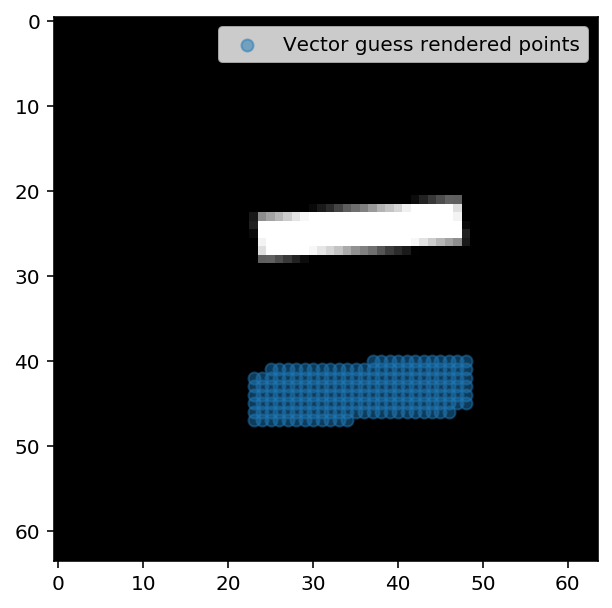

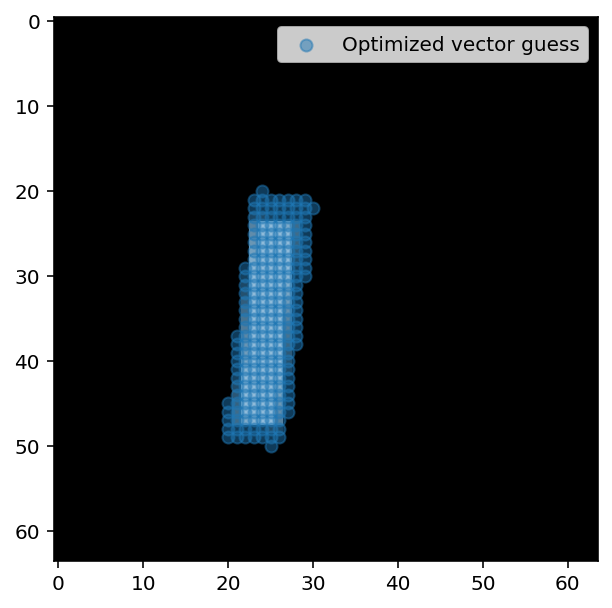

In [23]:
s = Synthetic(64, 64)
# random seed 111, line_batch = np.array([[[45., 24., 43., 48., 5., 0.5]]]).astype(np.float32), lr 0.5
np.random.seed(111)

image, _ = s.get_image('.', line_count=1)
image = 1 - np.array(image) / 255

raster_coords, raster_masses = get_pixel_coords_and_density(image)

line_batch = np.array([[[45., 24., 43., 48., 5., 0.5]]]).astype(np.float32)
line_batch = torch.from_numpy(line_batch)

visualize(DEFAULT_RENDERER, image, line_batch, 'Vector guess rendered points')

line_batch = optimize_line_batch(line_batch, raster_coords, raster_masses, n_iters=100, lr=0.5, length_loss=0.4, width_loss=0.4)
visualize(DEFAULT_RENDERER, image.T, line_batch, 'Optimized vector guess')

In [ ]:
line_batch

The second picture is transposed.

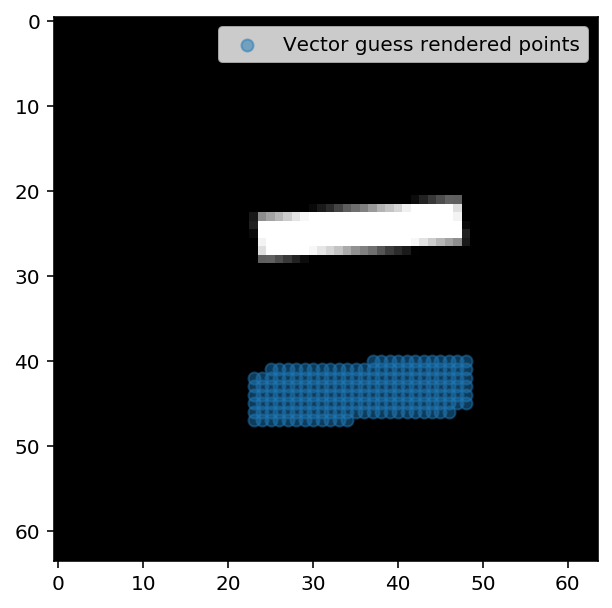

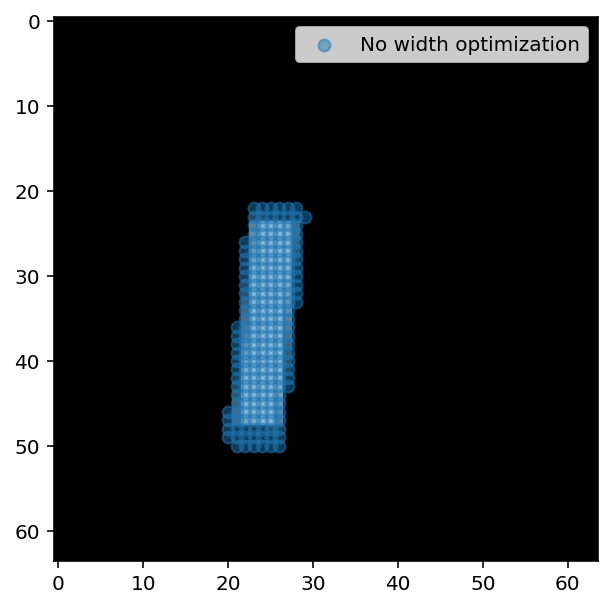

In [16]:
s = Synthetic(64, 64)
# random seed 111, line_batch = np.array([[[45., 24., 43., 48., 5., 0.5]]]).astype(np.float32), lr 0.5
np.random.seed(111)

image, _ = s.get_image('.', line_count=1)
image = 1 - np.array(image) / 255

raster_coords, raster_masses = get_pixel_coords_and_density(image)

line_batch = np.array([[[45., 24., 43., 48., 5., 0.5]]]).astype(np.float32)
line_batch = torch.from_numpy(line_batch)

visualize(DEFAULT_RENDERER, image, line_batch, 'Vector guess rendered points')

line_batch = optimize_line_batch(line_batch, raster_coords, raster_masses, lr=0.5, optimize_width=False, length_loss=0.4)
visualize(DEFAULT_RENDERER, image.T, line_batch, 'No width optimization')

Another one-line transport:

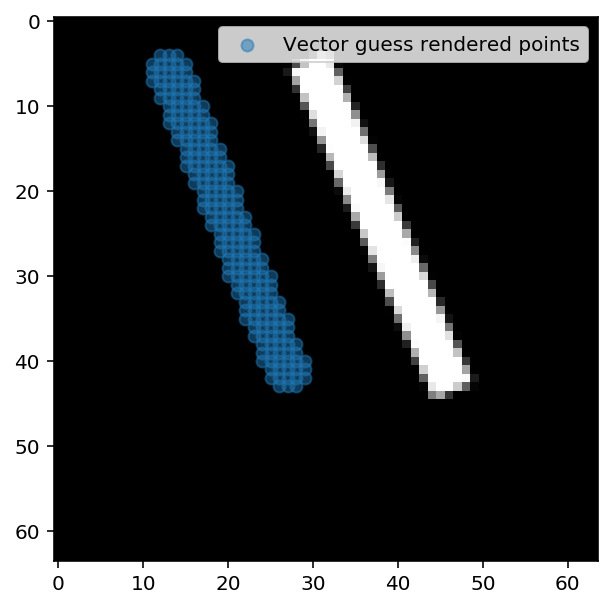

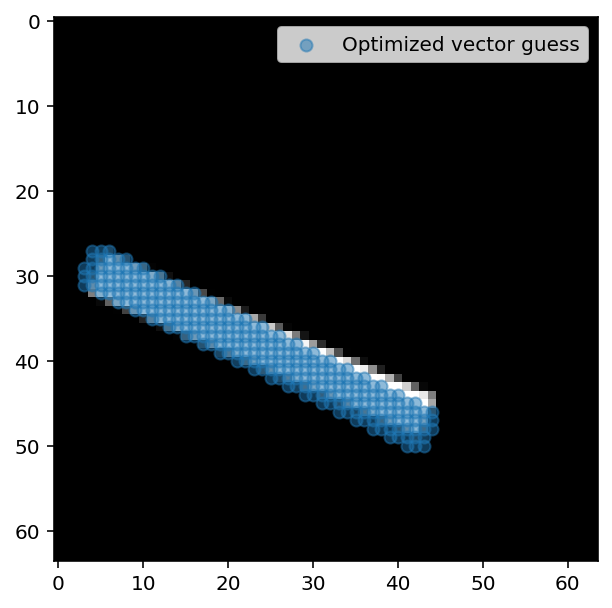

In [17]:
np.random.seed(112)

image, _ = s.get_image('.', line_count=1)
image = 1 - np.array(image) / 255

raster_coords, raster_masses = get_pixel_coords_and_density(image)

line_batch = np.array([[[5., 13., 43., 28., 3., 0.5]]]).astype(np.float32)
line_batch = torch.from_numpy(line_batch)

visualize(DEFAULT_RENDERER, image, line_batch, 'Vector guess rendered points')

line_batch = optimize_line_batch(line_batch, raster_coords, raster_masses, n_iters=100, lr=0.2, coord_only_steps=80, length_loss=0.4, optimize_width=True)
visualize(DEFAULT_RENDERER, image.T, line_batch, 'Optimized vector guess')

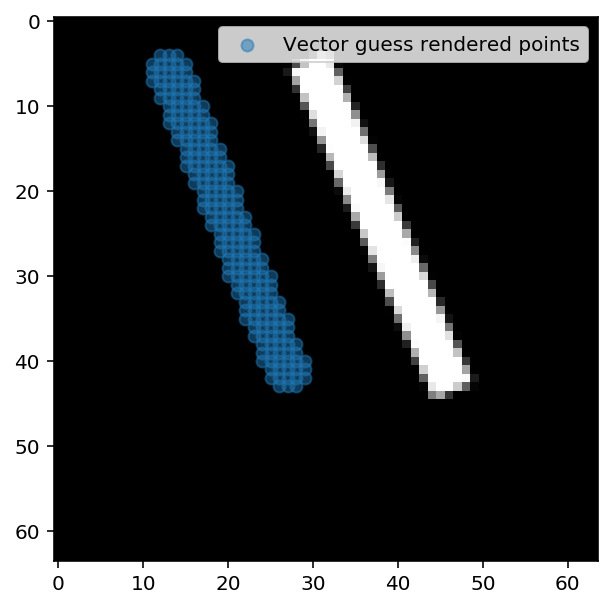

In [9]:
s = Synthetic(64, 64)
np.random.seed(112)

image, _ = s.get_image('.', line_count=1)
image = 1 - np.array(image) / 255

raster_coords, raster_masses = get_pixel_coords_and_density(image)

line_batch = np.array([[[5., 13., 43., 28., 3., 0.5]]]).astype(np.float32)
line_batch = torch.from_numpy(line_batch)

visualize(DEFAULT_RENDERER, image, line_batch, 'Vector guess rendered points')

line_batch = optimize_line_batch(line_batch, raster_coords, raster_masses, n_iters=70, lr=0.2, optimize_width=True)

## More lines

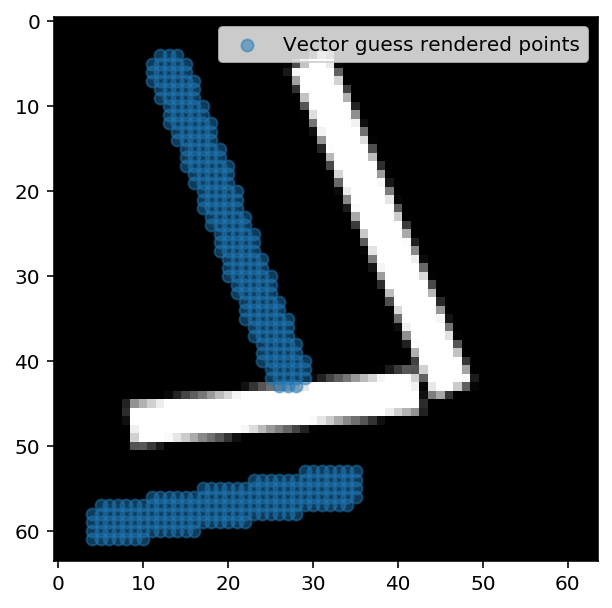

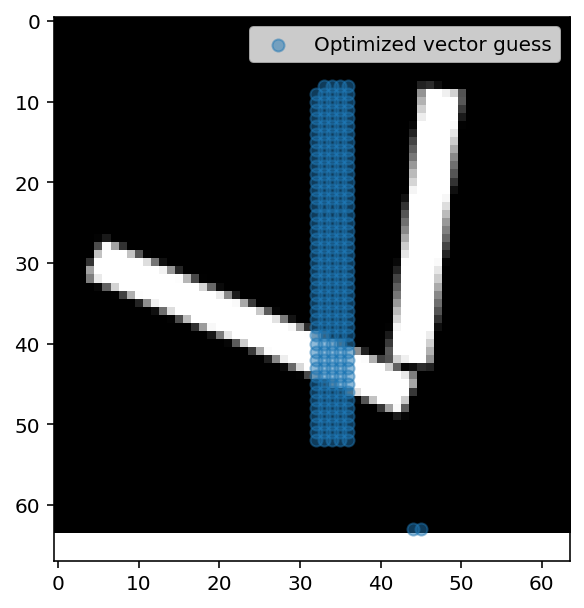

In [26]:
np.random.seed(112)

image, _ = s.get_image('.', line_count=2)
image = 1 - np.array(image) / 255

raster_coords, raster_masses = get_pixel_coords_and_density(image)

line_batch = np.array([[[5., 13., 43., 28., 3., 0.5], [60., 5., 55., 35., 3., 0.5]]]).astype(np.float32)
line_batch = torch.from_numpy(line_batch)

visualize(DEFAULT_RENDERER, image, line_batch, 'Vector guess rendered points')

line_batch = optimize_line_batch(line_batch, raster_coords, raster_masses, n_iters=100, lr=0.2, optimize_width=True, 
                                 graph=False, coord_only_steps=70, length_loss=0.5)
visualize(DEFAULT_RENDERER, image.T, line_batch, 'Optimized vector guess')

In [ ]:
np.random.seed(114)

image, _ = s.get_image('.', line_count=2)
image = 1 - np.array(image) / 255

raster_coords, raster_masses = get_pixel_coords_and_density(image)

line_batch = np.array([[[5., 13., 15., 40., 1., 0.5], [30., 15., 48., 17., 2., 0.5]]]).astype(np.float32)
line_batch = torch.from_numpy(line_batch)

visualize(DEFAULT_RENDERER, image, line_batch, 'Vector guess rendered points')

line_batch = optimize_line_batch(line_batch, raster_coords, raster_masses, n_iters=100, lr=0.2, optimize_width=True, 
                                 graph=False, coord_only_steps=100, length_loss=5.)
visualize(DEFAULT_RENDERER, image.T, line_batch, 'Optimized vector guess')

In [ ]:
def make_demo(random_seed, line_count, line_batch, **opt_kwargs):
    np.random.seed(random_seed)
    
    image, _ = s.get_image('.', line_count=line_count)
    image = 1 - np.array(image) / 255
    
    raster_coords, raster_masses = get_pixel_coords_and_density(image)
    
    line_batch = torch.from_numpy(line_batch)
    
    visualize(DEFAULT_RENDERER, image, line_batch, 'Vector guess rendered points')
    
    line_batch = optimize_line_batch(line_batch, raster_coords, raster_masses, **opt_kwargs)
    visualize(DEFAULT_RENDERER, image.T, line_batch, 'Optimized vector guess')

The result is quite as expected — we have to control the total pixel mass in the rendering to be constant (or at least make changes of mass cost a lot).
